<a href="https://colab.research.google.com/github/lasentia/Analysis_of_card_dropout_rates_project/blob/main/2%ED%8C%80_2%EC%A1%B0/StepWise_OLS_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 변수 단계별 선택법을 사용한 로지스틱 회귀분석

In [4]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [5]:
df = pd.read_csv('/content/BankChurners.csv')
df.replace({"Attrited Customer":1, "Existing Customer":0}, inplace=True)
cols = ['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']
df.drop(cols, axis=1, inplace=True)

# #One-Hot Encoding
# 범주형 변수 선택
cols = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

# One-Hot Encoding 적용 및 기존 데이터프레임에 추가
for col in cols:
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)

# 원래 범주형 변수 열 삭제
df.drop(cols, axis=1, inplace=True)

# 결과 확인
df.head()


,CLIENTNUM,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,768805383,0,45,3,39,5,1,3,12691.0,777,...,0,0,1,0,0,0,1,0,0,0
1,818770008,0,49,5,44,6,1,2,8256.0,864,...,0,0,0,0,1,0,1,0,0,0
2,713982108,0,51,3,36,4,1,0,3418.0,0,...,0,0,0,1,0,0,1,0,0,0
3,769911858,0,40,4,34,3,4,1,3313.0,2517,...,0,0,0,0,1,0,1,0,0,0
4,709106358,0,40,3,21,5,1,0,4716.0,0,...,0,0,1,0,0,0,1,0,0,0


In [7]:
import statsmodels.api as sm
# 독립 변수와 종속 변수 분리
X = df.drop(['Attrition_Flag'], axis=1)
y = df['Attrition_Flag']
seed = 42

# 데이터를 학습 데이터와 테스트 데이터로 분리
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=seed)

train_X = sm.add_constant(train_X)
model = sm.OLS(train_y, train_X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Attrition_Flag   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     156.9
Date:                Thu, 18 Jan 2024   Prob (F-statistic):               0.00
Time:                        17:28:57   Log-Likelihood:                -1415.6
No. Observations:                8101   AIC:                             2897.
Df Residuals:                    8068   BIC:                             3128.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

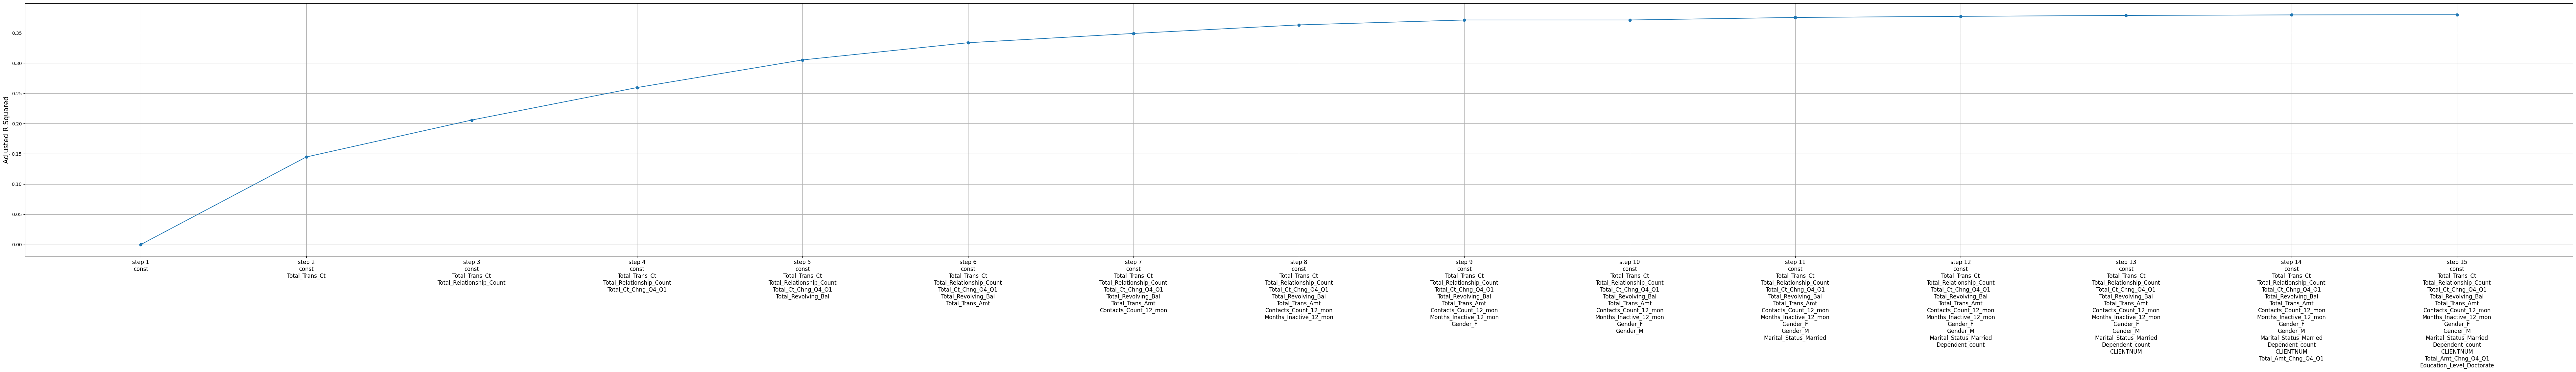

['const',
 'Total_Trans_Ct',
 'Total_Relationship_Count',
 'Total_Ct_Chng_Q4_Q1',
 'Total_Revolving_Bal',
 'Total_Trans_Amt',
 'Contacts_Count_12_mon',
 'Months_Inactive_12_mon',
 'Gender_F',
 'Gender_M',
 'Marital_Status_Married',
 'Dependent_count',
 'CLIENTNUM',
 'Total_Amt_Chng_Q4_Q1',
 'Education_Level_Doctorate']

In [16]:
#단계 선택법 알고리즘

def stepwise_feature_selection(train_X, train_y, variables=train_X.columns.tolist() ):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    import warnings
    warnings.filterwarnings("ignore")

    y = train_y ## 반응 변수

    selected_variables = [] ## 선택된 변수들
    sl_enter = 0.05
    sl_remove = 0.05

    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) ## 변수의 p-value
        ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
        ## 선형 모형을 적합한다.
        for col in remainder:
            X = train_X[selected_variables+[col]]
            X = sm.add_constant(X)
            model = sm.OLS(y,X).fit(disp=0)
            pval[col] = model.pvalues[col]

        min_pval = pval.min()
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
            selected_variables.append(pval.idxmin())
            ## 선택된 변수들에대해서
            ## 어떤 변수를 제거할지 고른다.
            while len(selected_variables) > 0:
                selected_X = train_X[selected_variables]
                selected_X = sm.add_constant(selected_X)
                selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다
                max_pval = selected_pval.max()
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                    remove_variable = selected_pval.idxmax()
                    selected_variables.remove(remove_variable)
                else:
                    break

            step += 1
            steps.append(step)
            adj_r_squared = sm.OLS(y,sm.add_constant(train_X[selected_variables])).fit(disp=0).rsquared_adj
            adjusted_r_squared.append(adj_r_squared)
            sv_per_step.append(selected_variables.copy())
        else:
            break

    fig = plt.figure(figsize=(100,10))
    fig.set_facecolor('white')

    font_size = 15
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
    plt.plot(steps,adjusted_r_squared, marker='o')

    plt.ylabel('Adjusted R Squared',fontsize=font_size)
    plt.grid(True)
    plt.show()

    return selected_variables


selected_variables = stepwise_feature_selection(train_X, train_y)
selected_variables

In [13]:
#다중선형회귀분석 및 결과 -> 설명력 0.38로 낮음..
model = sm.OLS(train_y, sm.add_constant(pd.DataFrame(train_X[selected_variables]))).fit(disp=0)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Attrition_Flag   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     382.8
Date:                Thu, 18 Jan 2024   Prob (F-statistic):               0.00
Time:                        17:36:16   Log-Likelihood:                -1432.8
No. Observations:                8101   AIC:                             2894.
Df Residuals:                    8087   BIC:                             2992.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [15]:
#선택된 변수들로 로지스틱 회귀분석  -> 오류 발생 (다중공신성 때문인듯 아직 해결 못함)
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# 선택된 변수들로 데이터프레임 생성
X_selected = train_X[selected_variables]

# 데이터를 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X_selected, train_y, test_size=0.2, random_state=42)

# 데이터 표준화 (선택 변수들 간의 스케일을 맞추기 위해)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 로지스틱 회귀 모델 피팅
logit_model = sm.Logit(y_train, sm.add_constant(X_train_scaled))
result = logit_model.fit()

# 회귀분석 결과 출력
print(result.summary())

# 예측 및 평가
X_test_scaled_const = sm.add_constant(X_test_scaled)
y_pred = result.predict(X_test_scaled_const) > 0.5  # 0.5 기준으로 이진 분류
accuracy = accuracy_score(y_test, y_pred)

print("\nAccuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Optimization terminated successfully.
         Current function value: 0.234412
         Iterations 8


LinAlgError: Singular matrix